# Import all libraries

*cv2*: OpenCV library, which provides tools for computer vision tasks such as image processing, feature detection, and object recognition.

*numpy*: numerical computing, which is commonly used for data manipulation and array operations.

*tensorflow*: Main library of machine learning for building and training deep learning models.

*tensorflow_datasets*: Provides preprocessed datasets for machine learning tasks.

*matplotlib*: Creating visualizations, which may be used for plotting model performance during training.

*import of Dense, Conv2D, MaxPooling2D, Flatten, Dropout, and BatchNormalization*: These are Keras layers from TensorFlow that can be used to build neural networks for various machine learning tasks, more for image classification.

Installing libraries with *pip*

In [ ]:
!pip install opencv-python numpy matplotlib tensorflow tensorflow_datasets

In [10]:
import os
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

## Set hyperparameters, for affect model performance
batch_size - how much images the model will process at a time during each training iteration.
epochs - number of model iterations during training process
validation_split - split train data for validation during training process

In [11]:
dataset_name = 'cifar10'
image_directory = 'random_images'
batch_size = 128
n_epochs = 30
tensorboard_callback = TensorBoard(log_dir=f'logs/{dataset_name}')
stop_val_loss = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
stop_val_accuracy = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=20)
lr_schedule_val_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

Load the CIFAR-10 dataset, which is a collection of 50,000 training images and 10,000 test images, where each image belongs to one of 10 classes. Link: https://paperswithcode.com/dataset/cifar-10

Load data and split to train and test

In [12]:
_, info = tfds.load(dataset_name, split=['train', 'test'], with_info=True)
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

Get all class names of dataset CIFAR-100 and number of classes, get shape of
img

In [13]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
input_shape = info.features['image'].shape

print(f"Size of classes: {n_classes}, and their names is: {class_names}")
print(f"Shape of data: {input_shape}")

Size of classes: 10, and their names is: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Shape of data: (32, 32, 3)


## Visualisation of CIFAR-10 data.
Generates a grid of 16 random images with their corresponding labels. Take 16 images from train_data. For each image, its corresponding label is used to set the title.

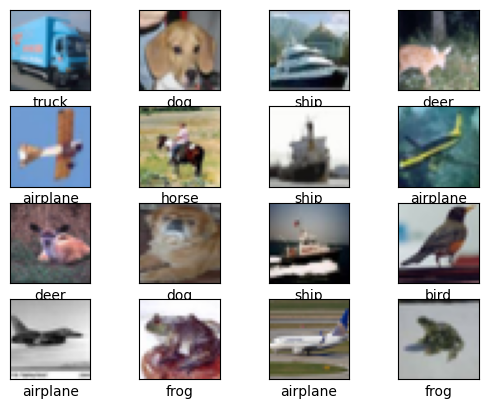

In [14]:
random_nums = [random.randint(0, 50000) for _ in range(16)]

for random, i in zip(random_nums, range(16)):
  plt.subplot(4, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_data[random], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[random][0]])
plt.show()

Preprocess data for model trainings

In [15]:
train_data = train_data / 255
test_data = test_data / 255

train_labels, test_labels = train_labels.flatten(), test_labels.flatten()

## Convolutional Neural Network model creating

Sequential model that consists of several layers:

* `Conv2D`: Performs 2D convolution on the input data. Takes 32, 64 or 128 number of filters, filter/kernel size (3x3 in this case), the 'same' padding argument ensures that the output feature map has the same spatial dimensions as the input feature map. The activation function used is ReLU(simple non-linear function that takes the maximum between the input value and 0).
* `MaxPooling2D`: Performs max pooling on the output of the previous Conv2D layer. The pool size is (2, 2), which reduces the spatial dimensions of the feature map by half.
* `Dropout`: Randomly drops out a certain proportion of neurons of the input units to prevent overfitting.
* `Flatten`: Flattens the output of the previous layer to a 1D array to prepare it for the fully connected layers.
* `Dense`: Fully connected layer with X units(512 in this case) and uses the ReLU activation function. The last Dense layer has number of classes units and uses the softmax activation function to produce class probabilities.

In [16]:
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=input_shape, activation='relu'),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(n_classes, activation='softmax'),
])

model.summary()

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(train_data, train_labels, epochs=n_epochs,
                 validation_data=(test_data, test_labels),
                 callbacks=[tensorboard_callback, lr_schedule_val_loss, stop_val_loss, stop_val_accuracy],
                 batch_size=batch_size,
                 steps_per_epoch=len(train_data) // batch_size,
                 validation_steps=len(test_data) // batch_size)

Epoch 1/30


2023-05-12 10:56:20.993452: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


390/390 [==============================] - 46s 118ms/step - loss: 1.6613 - acc: 0.4169 - val_loss: 3.0025 - val_acc: 0.1001 - lr: 0.0010
Epoch 2/30
390/390 [==============================] - 51s 130ms/step - loss: 1.1433 - acc: 0.5996 - val_loss: 3.7959 - val_acc: 0.2086 - lr: 0.0010
Epoch 3/30
225/390 [================>.............] - ETA: 20s - loss: 0.9251 - acc: 0.6801

KeyboardInterrupt: 

In [17]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

train_generator = datagen.flow(train_data, train_labels, batch_size=batch_size)
test_generator = datagen.flow(test_data, test_labels, batch_size=batch_size)

history2 = model.fit(train_generator, epochs=n_epochs,
                 validation_data=test_generator,
                 callbacks=[tensorboard_callback, lr_schedule_val_loss, stop_val_loss, stop_val_accuracy],
                 batch_size=batch_size,
                 steps_per_epoch=len(train_data) // batch_size,
                 validation_steps=len(test_data) // batch_size)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [61]:
loss, accuracy = model.evaluate(test_data, test_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

## Visualizing the performance of a deep learning CNN model
Visualize data, that have been got after training process of model. Visulization of loss and accuracy line charts. During data watching can be identified some overfitting or underfitting of model


Also for take a look for model training proccesses you can go to terminal execute *tensorboard --logdir=logs/* and go to http://localhost:6006/ , this is user interface of model training with TensorBoard

In [36]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

ax1.plot(history.history['loss'], 'red', linewidth=2.0)
ax1.plot(history.history['val_loss'], 'orange', linewidth=2.0)
ax1.plot(history2.history['loss'], 'blue', linewidth=2.0)
ax1.plot(history2.history['val_loss'], 'cyan', linewidth=2.0)
ax1.legend(['[Simple data] Training Loss', '[Simple data] Validation Loss', '[Data augmentation] Training Loss', '[Data augmentation] Validation Loss'], fontsize=12)
ax1.set_xlabel('Epochs', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Loss Curves', fontsize=16)
ax1.grid(True)

ax2.plot(history.history['acc'], 'red', linewidth=2.0)
ax2.plot(history.history['val_acc'], 'orange', linewidth=2.0)
ax2.plot(history2.history['acc'], 'blue', linewidth=2.0)
ax2.plot(history2.history['val_acc'], 'cyan', linewidth=2.0)
ax2.legend(['[Simple data] Training Accuracy', '[Simple data] Validation Accuracy', '[Data augmentation] Training Accuracy', '[Data augmentation] Validation Accuracy'], fontsize=12)
ax2.set_xlabel('Epochs', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
ax2.set_title('Accuracy Curves', fontsize=16)
ax2.grid(True)

plt.show()

313/313 [==============================] - 6s 19ms/step - loss: 0.4504 - acc: 0.8497
Loss: 0.450377881526947, Accuracy: 0.8496999740600586


Visualize the model's predictions on a set of test data

Iterates over the first 25 images in the test data and plots them on each subplot. Set title of true data class and predictioned class

313/313 [==============================] - 4s 14ms/step


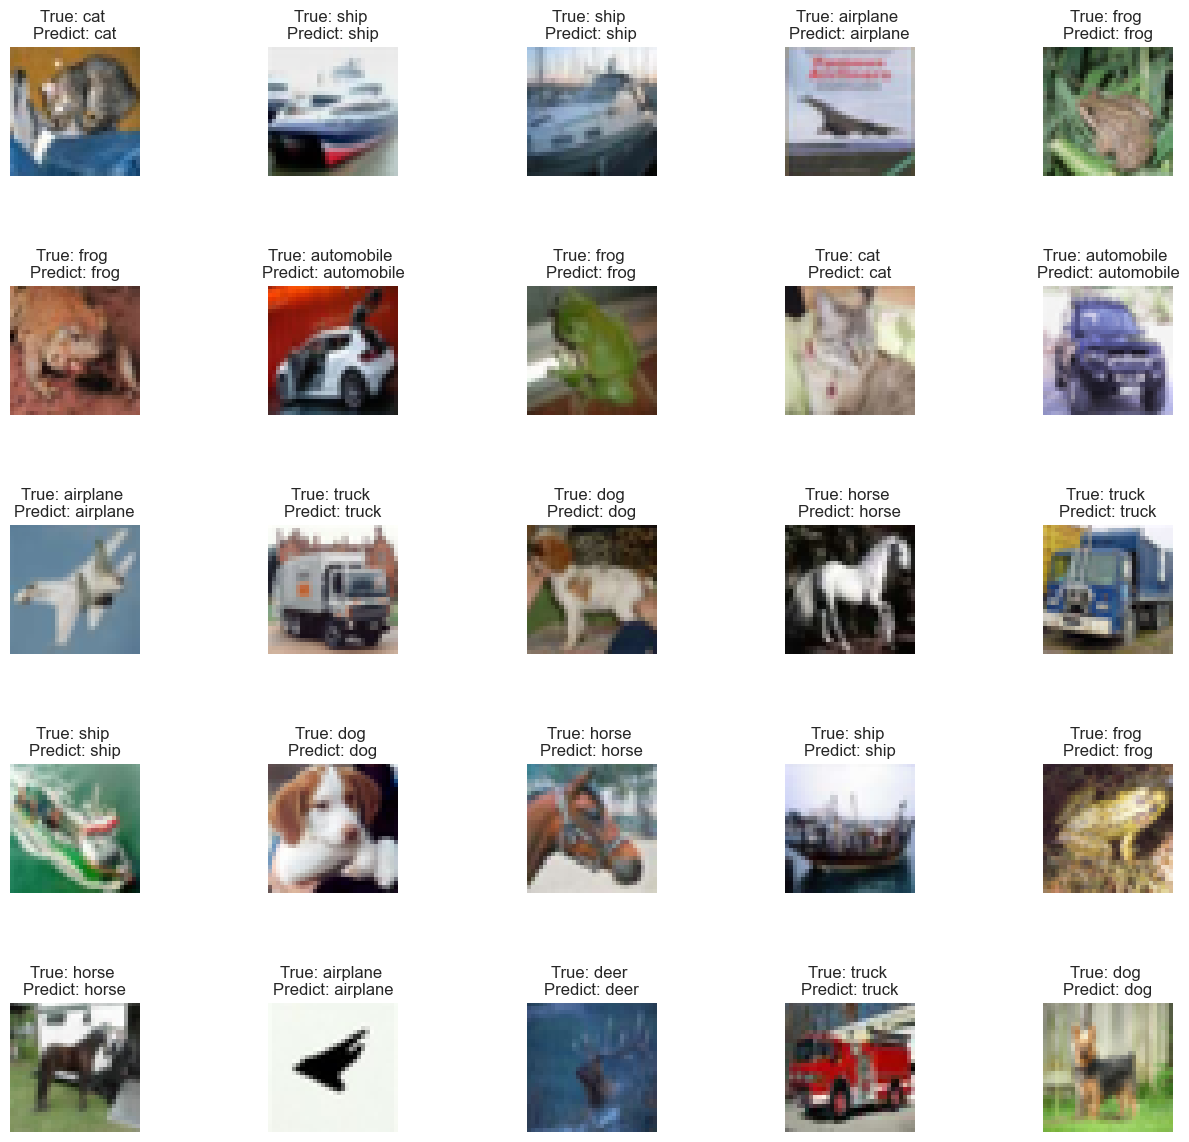

In [51]:
pred = model.predict(test_data)
pred_classes = np.argmax(pred, axis=1)

fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(test_data[i])
    axes[i].set_title("True: %s \nPredict: %s" % (class_names[test_labels[i]], class_names[pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

Method for getting top prediction classes and names on some predictioned image, for visualizing this data on bar chart

In [52]:
def get_top_predictions(prediction):
    top_probs_indices = np.argsort(prediction)[0][::-1][:10]
    top_probs = prediction[0][top_probs_indices]
    top_class_names = [class_names[i] for i in top_probs_indices]
    return top_class_names, top_probs

### Data prediction with random images(data)

Loops over some random images, load it with OpenCV, resizing to 32x32, then make prediction with model and ploting the original image and the corresponding probabilities of each class(with method get_top_predictions)

The resulting figure shows the original image with its predicted class and a bar chart of the probabilities for the top predicted classes.

1/1 [==============================] - 0s 11ms/step


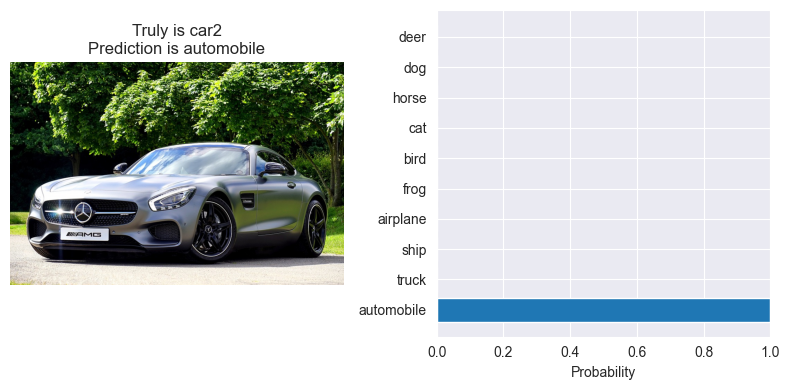

1/1 [==============================] - 0s 11ms/step


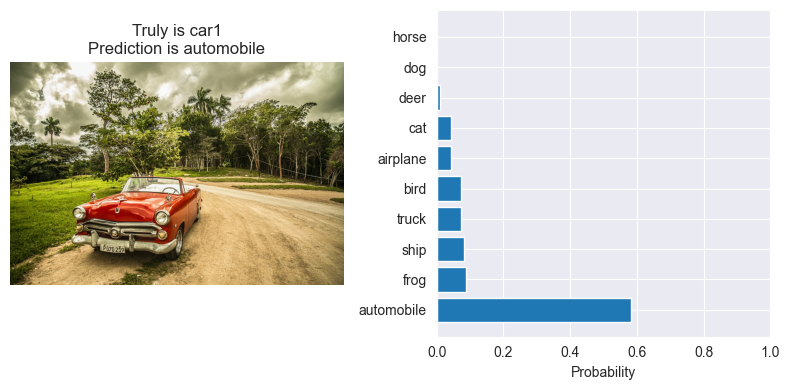

1/1 [==============================] - 0s 11ms/step


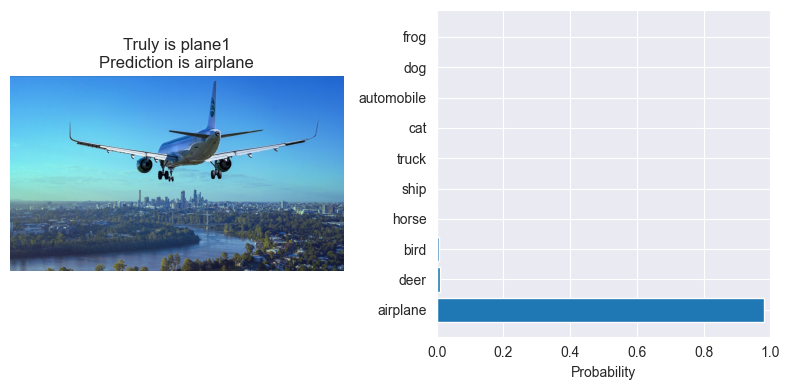

1/1 [==============================] - 0s 10ms/step


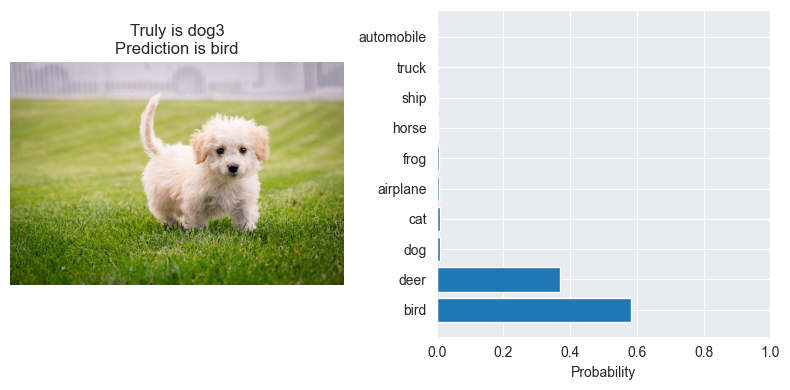

1/1 [==============================] - 0s 10ms/step


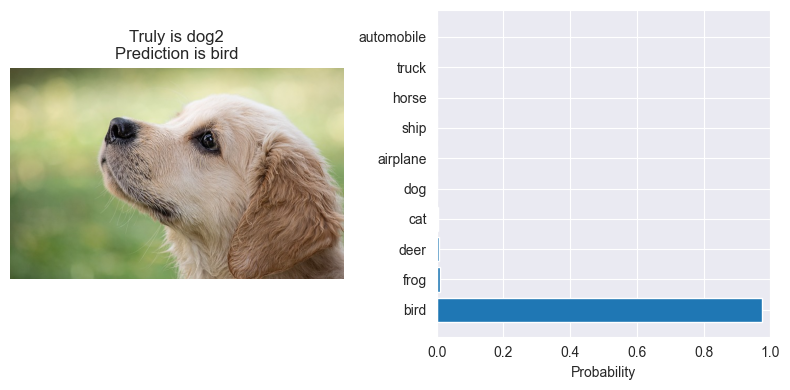

1/1 [==============================] - 0s 9ms/step


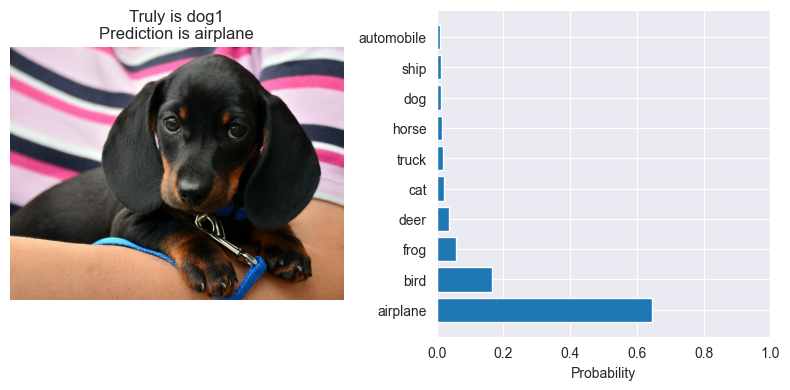

1/1 [==============================] - 0s 10ms/step


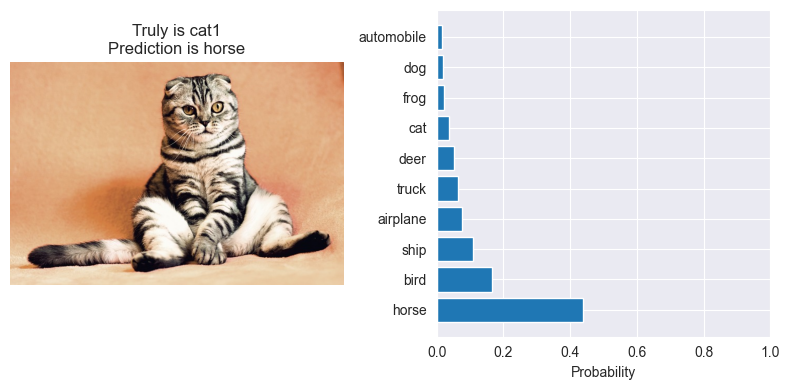

1/1 [==============================] - 0s 10ms/step


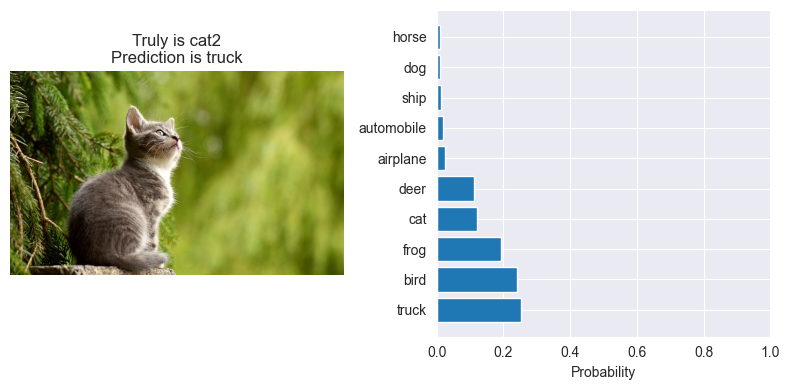

1/1 [==============================] - 0s 10ms/step


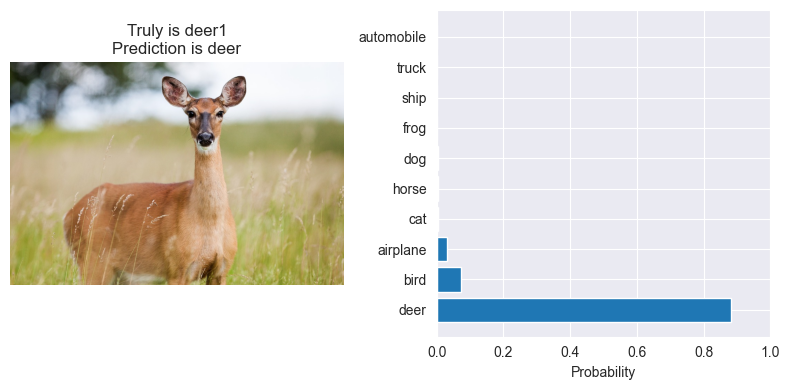

1/1 [==============================] - 0s 10ms/step


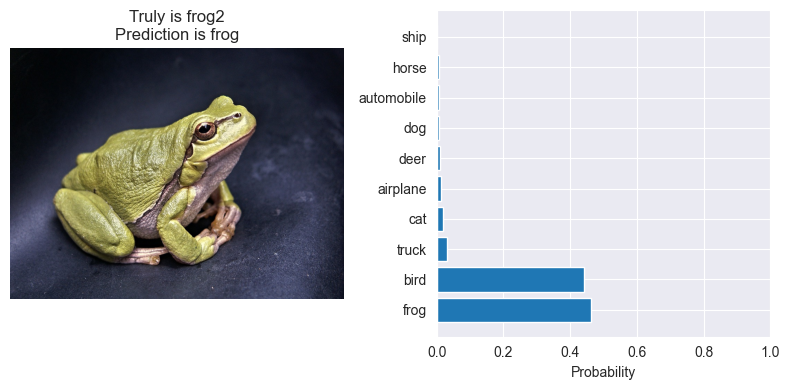

1/1 [==============================] - 0s 11ms/step


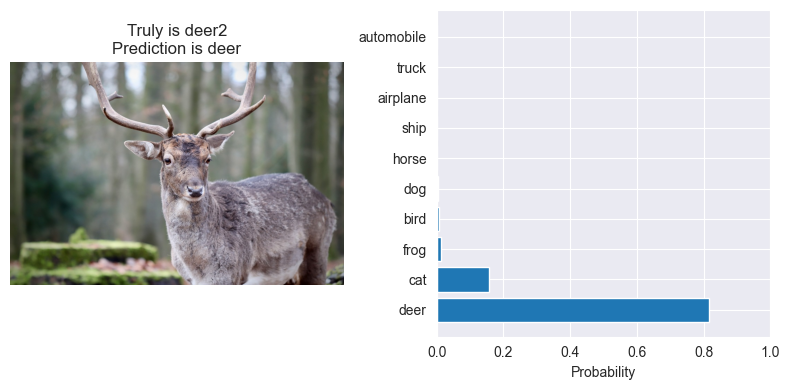

1/1 [==============================] - 0s 11ms/step


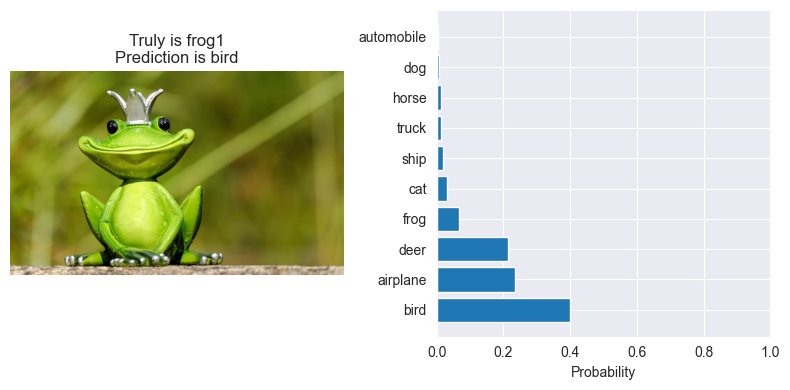

1/1 [==============================] - 0s 10ms/step


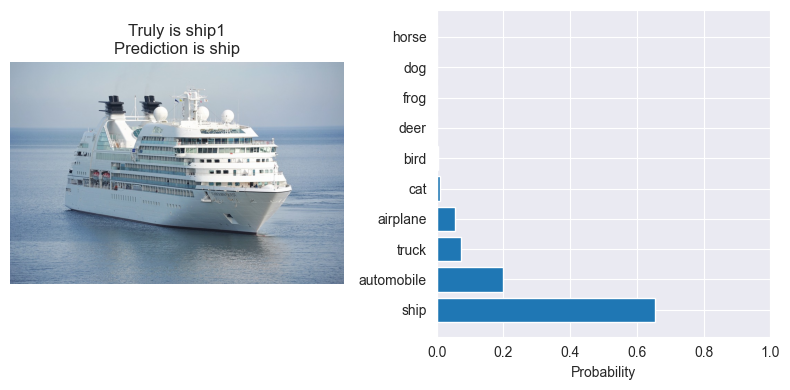

1/1 [==============================] - 0s 10ms/step


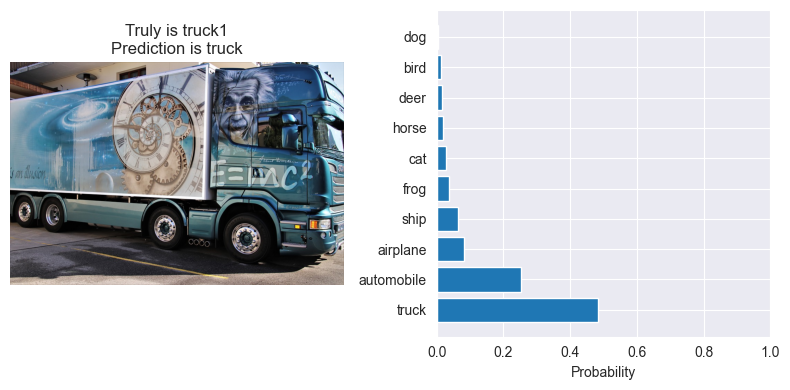

1/1 [==============================] - 0s 10ms/step


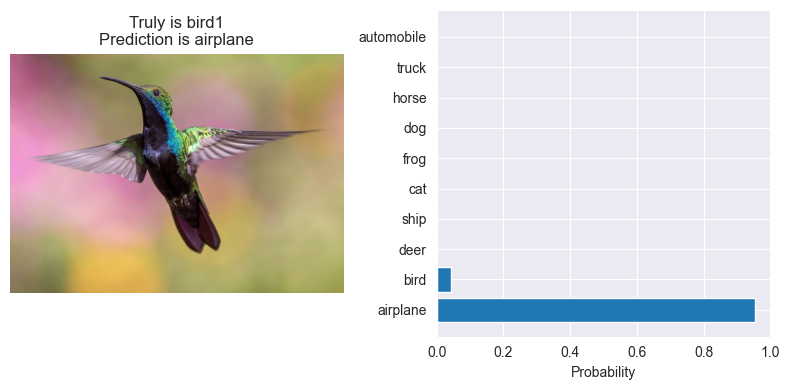

1/1 [==============================] - 0s 12ms/step


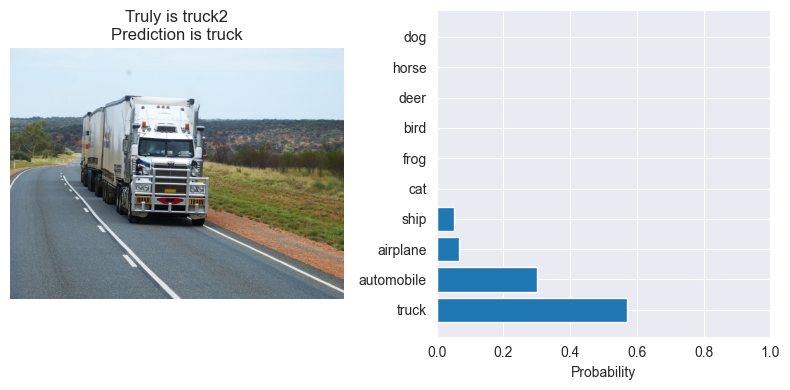

1/1 [==============================] - 0s 10ms/step


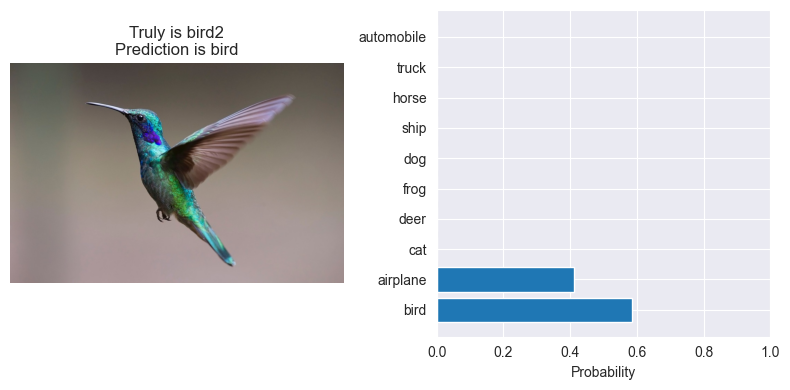

1/1 [==============================] - 0s 9ms/step


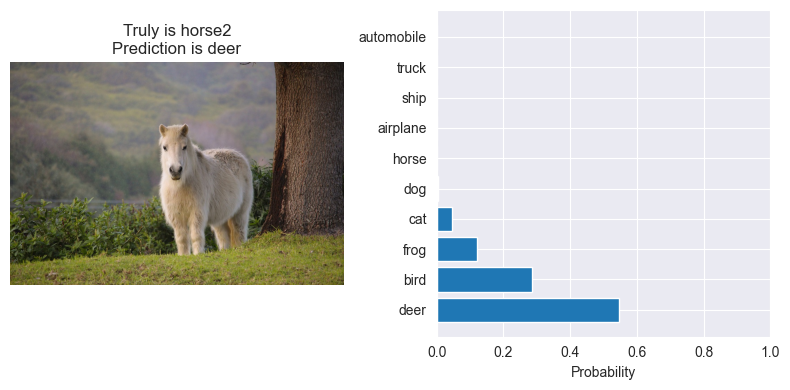

1/1 [==============================] - 0s 9ms/step


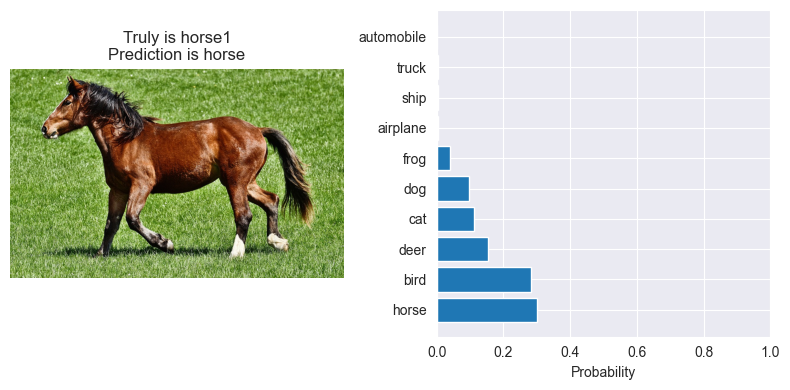

In [53]:
for filename in os.listdir(image_directory):
  if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
    plot_img = cv.imread(f"{image_directory}/{filename}")
    plot_img = cv.cvtColor(plot_img, cv.COLOR_BGR2RGB)

    img = cv.imread(f"{image_directory}/{filename}")
    img = cv.resize(img, (32, 32))
    img = np.expand_dims(img, axis=0) / 255.0

    prediction = model.predict(img)
    index = np.argmax(prediction)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

    ax1.set_title(f"Truly is {filename.split('.')[0]}\nPrediction is {class_names[index]}")
    ax1.imshow(plot_img)
    ax1.axis("off")

    top_names, top_predictions = get_top_predictions(prediction)
    ax2.barh(top_names, top_predictions)
    ax2.set_xlabel("Probability")
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()